In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/translating-images-into-maps


In [2]:
%matplotlib inline

In [49]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [3]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import cv2

In [4]:
from src.data.dataloader_light import nuScenesMaps, read_split

from argslib import parse_args, init
from visualization import color_components, make_composite, plot_ground_truth, COLOR_MAP, color_map_labels, visualize_prediction

In [5]:
import torch

In [6]:
args = parse_args(notebook=True)
args.root = '/Users/deepakduggirala/Documents/autonomous-robotics/v1.0-trainval_meta/'
args.val_split = 'evaluation'
init(args)

In [210]:
epoch = 26
res_100 = torch.load(f'experiments/tiim_28k-exp6/inference_results/ckpt-{epoch}-val-pred-100x100.pt')

In [8]:
val_data = nuScenesMaps(
        root=args.root,
        split=args.val_split,
        grid_size=args.grid_size,
        grid_res=args.grid_res,
        classes=args.load_classes_nusc,
        dataset_size=args.data_size,
        desired_image_size=args.desired_image_size,
        mini=True,
        gt_out_size=(100, 100),
        nusc_data_file='eval_data.pickle'
    )

/Users/deepakduggirala/miniforge3/envs/tim/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1670076285409/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


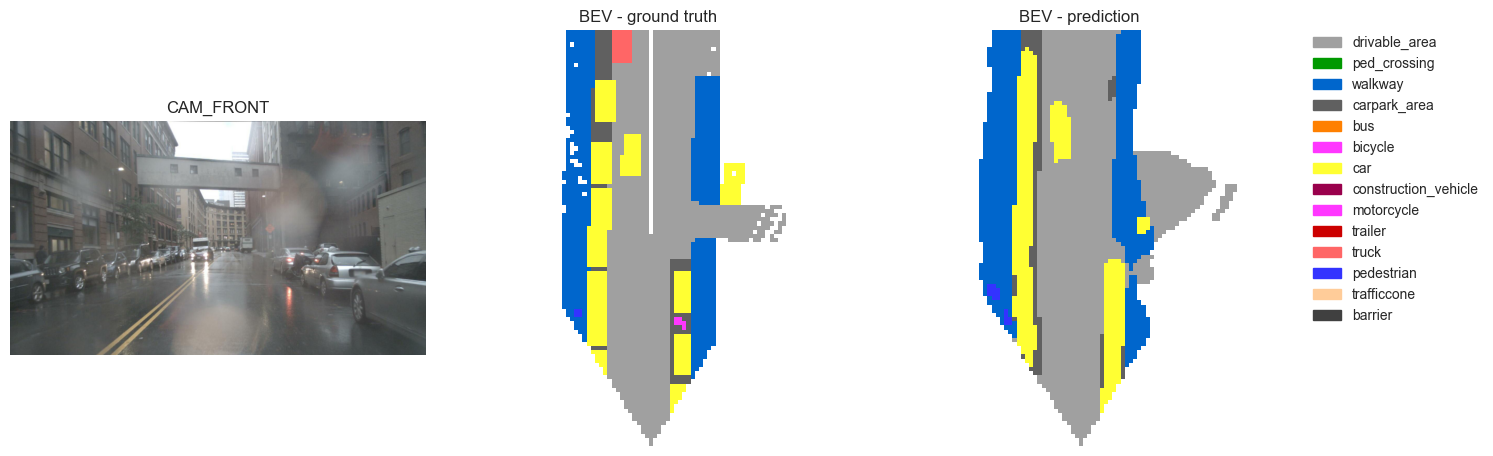

In [211]:
i_sample = 26
image, cls_maps, vis_mask, calib, grid2d = val_data.__getitem__(i_sample)
pred = torch.sigmoid(res_100[i_sample])
visualize_prediction(image, cls_maps, pred, figsize=(15, 10))

In [ ]:
# for i_sample in range(res_100.shape[0]):
#     image, cls_maps, vis_mask, calib, grid2d = val_data.__getitem__(i_sample)
#     pred = torch.sigmoid(res_100[i_sample])
#     visualize_prediction(image, cls_maps, pred, figsize=(15, 10), out_path=f'results/pred_{i_sample}_epoch_{epoch}.png', dpi=100)

## Loop over epochs - animation

In [62]:
def f(i_sample, epoch):
    image, cls_maps, vis_mask, calib, grid2d = val_data.__getitem__(i_sample)
    
    fname = f'experiments/tiim_28k-exp6/inference_results/ckpt-{epoch}-val-pred-100x100.pt'
    # print(fname)
    res_100 = torch.load(fname)
    pred = torch.sigmoid(res_100[i_sample])
    
    composite_pred = make_composite(pred)
    pred_colors = cv2.flip(color_components(composite_pred.numpy()), 0)
    return pred_colors

MovieWriter imagemagick unavailable; using Pillow instead.


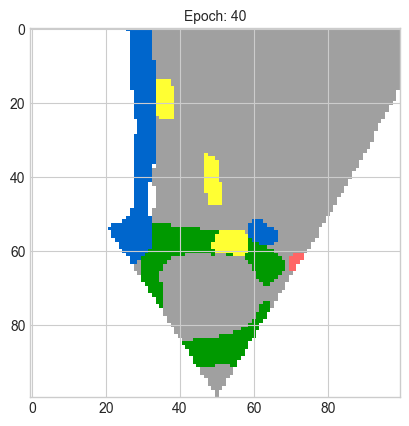

In [ ]:
fig, ax = plt.subplots()

i_sample=52
ims = []

for epoch in list(range(1,10)) + list(range(11,41)):
    ttl = plt.text(0.5, 1.01, f'Epoch: {epoch}', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    # txt = plt.text(epoch,epoch,epoch)
    im = ax.imshow(f(i_sample, epoch), animated=True)
    if epoch == 1:
        # ttl = plt.text(0.5, 1.01, f'Epoch: {epoch}', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
        # txt = plt.text(epoch,epoch,epoch)
        ax.imshow(f(i_sample, epoch))  # show an initial one first
    ims.append([im, ttl])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
ani.save(f'{i_sample}.gif', writer='imagemagick')
# ani.save("movie.mp4")

## Confidence Maps

In [265]:
# def confmap(i_sample, epoch):
#     image, cls_maps, vis_mask, calib, grid2d = val_data.__getitem__(i_sample)
    
#     fname = f'experiments/tiim_28k-exp6/inference_results/ckpt-{epoch}-val-pred-100x100.pt'
#     # print(fname)
#     res_100 = torch.load(fname)
#     pred = torch.sigmoid(res_100[i_sample])
#     maxval, _ = torch.max(pred, axis=0)
#     return maxval.numpy()

def confmap(i_sample, epoch):
    image, cls_maps, vis_mask, calib, grid2d = val_data.__getitem__(i_sample)
    
    fname = f'experiments/tiim_28k-exp6/inference_results/ckpt-{epoch}-val-pred-100x100.pt'
    # print(fname)
    res_100 = torch.load(fname)
    pred = torch.sigmoid(res_100[i_sample])
    
    nc = pred.shape[0]
    class_idx = torch.arange(nc) + 1
    x = (pred > 0.5).float() * class_idx.view(-1, 1, 1)
    x_composite, _ = x.max(dim=0)
    x_composite = x_composite.numpy().astype(np.int32)-1
    
    x_val, y_val = np.indices((100, 100), dtype=np.int32)
    
    composite_scores = pred.numpy()[x_composite.flatten(), x_val.flatten(), y_val.flatten()].reshape(100,100)
    return composite_scores

MovieWriter imagemagick unavailable; using Pillow instead.


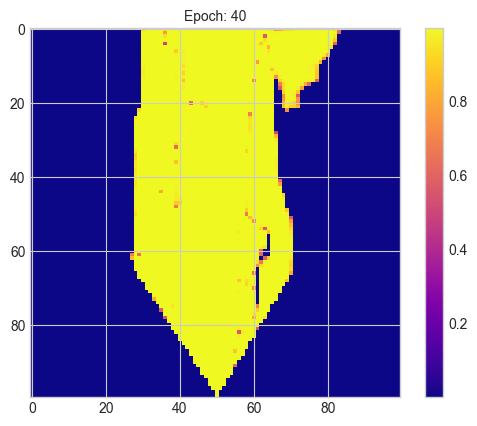

In [270]:
fig, ax = plt.subplots()
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)

i_sample=26
ims = []

for epoch in list(range(1,10)) + list(range(11,41)):
    ttl = plt.text(0.5, 1.01, f'Epoch: {epoch}', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    
    im = ax.imshow(cv2.flip(confmap(i_sample, epoch),0), animated=True, cmap='plasma', interpolation='nearest')
    if epoch == 1:
        img = ax.imshow(cv2.flip(confmap(i_sample, epoch),0), cmap='plasma', interpolation='nearest')  # show an initial one first
        fig.colorbar(img)
        # fig.colorbar(im, cax=cax, orientation='vertical')
        
    ims.append([im, ttl])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
ani.save(f'conf-map-composite-{i_sample}.gif', writer='imagemagick')
# ani.save("movie.mp4")

In [258]:
nc = pred.shape[0]
class_idx = torch.arange(nc) + 1
x = (pred > 0.5).float() * class_idx.view(-1, 1, 1)
x_composite, _ = x.max(dim=0)
x_composite = x_composite.numpy().astype(np.int32)-1

In [259]:
x_val, y_val = np.indices((100, 100), dtype=np.int32)

In [260]:
x = pred.numpy()[x_composite.flatten(), x_val.flatten(), y_val.flatten()].reshape(100,100)

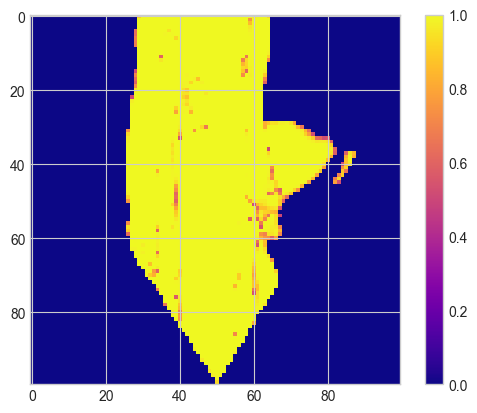

In [264]:
plt.imshow(cv2.flip(x,0), cmap='plasma', interpolation='nearest')
plt.colorbar()